# Analyzing Cultural Diversity through Census Data of Language Spoken at Home

By Jordan Crawford-O'Banner and Alli Busa

In the news, we've heard that diversity has increased in the United States. While the Census has praised the U.S. for becoming overall more racial and ethnically diverse, FOX newscaster Tucker Carlson has claimed that the rise of immigrants in the U.S. is not happening in "politicians' neighborhoods". (See Project Proposal)

We wanted to take these two clashing statements and put them both to the test. Has cultural diversity, measured through linguistic diversity, increased significantly in the past few years? How is cultural diversity, through linguistic diversity, spread out throughout the U.S.? Are regions with high ratios of non-English speakers actually linguistically diverse or homogenuously consisting of a non-English speaking community? 

## Importing Necessary Packages and Setting Up Data Imports

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white')

from thinkstats2 import Pmf, Cdf

import thinkstats2
import thinkplot

First we import the neccessary packages for analysis. 
We start by creating lists of strings to make iterating through excel sheets easier.

In [6]:
#Creating lists of strings to make iterating through excel sheets easier

#State abbreviations
#Taken from https://gist.github.com/JeffPaine/3083347
states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
"SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]

#State names
#Taken from https://gist.github.com/tleen/6299431
statesfull=['Alabama','Alaska','Arizona','Arkansas','California','Colorado','Connecticut',
            'District of Columbia','Delaware','Florida','Georgia',
            'Hawaii','Idaho','Illinois','Indiana','Iowa','Kansas','Kentucky','Louisiana','Maine',
            'Maryland','Massachusetts','Michigan','Minnesota','Mississippi','Missouri','Montana','Nebraska',
            'Nevada','New Hampshire','New Jersey','New Mexico','New York','North Carolina','North Dakota',
            'Ohio','Oklahoma','Oregon','Pennsylvania',
            'Rhode Island','South Carolina','South Dakota','Tennessee','Texas','Utah','Vermont',
            'Virginia','Washington','West Virginia','Wisconsin','Wyoming']

Here we create lists of the state names, which will help us index our data later on.

In [7]:
def createSeries(emptySeries, arrayNames, textfileName, index, Column, skiprows=[0,1,2]):
    """
    Makes a Series with specific language information from excel file. 
    It is used for organizing data on total English speakers and total non-English speakers.
    
    It takes in the name of an empty series, into which the data goes
                arrayNames - this will be either states or statesfull, depending on how Excel sheets are organized
                textfileName - the datafile
                index - either 0 for total English speakers or 1 for total non-English speakers
                Column - depending on the year, the column which contains the number of speakers is either given as "Number of speakers" or "Number of speakers1"
                skiprows - the number of rows before the data begins changes based on Excel file. For the 2006-2008 data, it is [0,1,2], for the 2009-2013 data, it is [0,1,2,3]
                
    """
    i=0
    for area in arrayNames:

        df = pd.read_excel(textfileName, area, skiprows=skiprows).dropna()

        #dictionary[area] = df.loc[dictionaryindex1:dictionaryindex1,Column]
        emptySeries.set_value(i,df.loc[index, Column])
        i+=1


The create Series function will allow us to create a pandas series from multiple sheets within an excel file. This is important because the data that has been provided to us for 2006 and 2009 has sepereated the data for each state onto a different sheet within the excel file.

In [8]:
#English and Non-English Speakers for 2000

#The file for the 2000 data was structured differently, so we made csv files from it 
#See how we did this in the Parse2000 notebook
english2000 = pd.read_csv("/home/jobanner/The-Mother-Tongue-of-US-Communities/eng2000state.csv").iloc[0]
other2000 = pd.read_csv("/home/jobanner/The-Mother-Tongue-of-US-Communities/other2000state.csv").iloc[0]
df2000=pd.DataFrame({"States": states,"English Speakers":english2000[:51],"SONELAHs":other2000[:51]})

In [9]:
#English and Non-English Speakers for 2006

#totallanguage_dict_06 = dict.fromkeys(states)
english2006=pd.Series()
other2006=pd.Series()
txtfile2006 = "/home/jobanner/The-Mother-Tongue-of-US-Communities/raw_data/DetailedLanguageSpoken_State_20062008.xls"

createSeries(english2006, states, txtfile2006, 1,"Number of speakers", skiprows=[0,1,2])
    
createSeries(other2006, states, txtfile2006, 2,"Number of speakers", skiprows=[0,1,2])

df2006=pd.DataFrame({"States": states,"English Speakers":english2006,"SONELAHs":other2006})

In [10]:
#English and Non-English Speakers for 2009, Creating dictionary and arrays

#totallanguage_dict_09 = dict.fromkeys(statesfull)
english2009=pd.Series()
other2009=pd.Series()
txtfile2009 =  "/home/jobanner/The-Mother-Tongue-of-US-Communities/raw_data/LanguageSpokenatHome_State_2009-2013.xls"

#things that are different about this file : skiprows is [0,1,2,3], column is "NumberofSpeakers1" and states is statesfull
createSeries(english2009, statesfull, txtfile2009, 1,"Number of speakers1", skiprows=[0,1,2,3])
    
createSeries(other2009, statesfull, txtfile2009, 2, "Number of speakers1", skiprows=[0,1,2,3])

df2009=pd.DataFrame({"States": states,"English Speakers":english2009,"SONELAHs":other2009})

These three cells take the the number of EOS and SONELAHs within each state and puts them into two seperate pandas series. Then the series are put into a dataframe that holds the state, how many EOS it has and how many SONELAHs it has.

## Initial Analysis - Probability Mass Functions (PMFs) 
We will begin by plotting PMFs to try to answer "Has cultural diversity, measured through linguistic diversity, increased significantly in the past few years? How is cultural diversity, through linguistic diversity, spread out throughout the U.S.? "

In [11]:
def plotPMFs(df):
    """
    Takes the number of only English speakers and number of speakers of other languages, per census file. 
    Returns two graphs with PMF of only English speakers and PMF of speakers of 
    other languages as normalized percentages of total population of those states. 
    """
    dft=df
    other_speakers=dft["SONELAHs"]
    english_speakers=dft["English Speakers"]
    dft["new_thing"] = other_speakers/(english_speakers+other_speakers)
    dft=dft.sort_values(by="new_thing")
    other_speakers_normalized=dft["new_thing"]
    i =0
    plt.figure(figsize=(20, 3))
    for thing in other_speakers_normalized:
        plt.bar(i, thing,  color='#B6D7A8')
        plt.autoscale(enable=True)
        plt.ylim([0.0,1.0])
        plt.xticks(range(0,51), dft["States"])
        plt.title("PMF of Speakers of Non-English Languages")
        plt.xlabel("State")
        plt.ylabel("Percantage of SONELAHs")
        i+=1

This function takes in a dataframe that corresponds to one of the years and plots the percentage of SONELAHs within each state from least to greatest

In [12]:
def plotLineGraph(otherspeakers2000, otherspeakers2006, otherspeakers2009, statelist):
    """
    Takes the information about non-English speakers in the 2000, 2006-2008 and 2009-2013 periods as well
    as which state you want to analyze.
    Returns a line graph which displays number of total speakers as a function of time
    Also returns a string of the state name, so that it is easier to plot the legend 
    """
    fig, axes = plt.subplots(nrows=10, ncols=5, figsize=(8,8),  sharex=True, sharey=True)
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    counteri = 0
    counterj = 0
    for state in statelist:

        indexstate = states.index(state) #finds the index of the state, in order to input into the series
        years = [2000,2006,2009]  #the initial years of the census data which we have 
        state_num = [otherspeakers2000[indexstate],otherspeakers2006[indexstate], otherspeakers2009[indexstate]] # the output
        axes[counteri,counterj].plt.plot(years, [x / 1000 for x in state_num], '-o', label = str(state)) #dividing by 1000 in order to make numbers smaller
        plt.title("Number of SONELAHs in"+str(state)+" in the 2000-2009 Time Frame")
        plt.xlabel("Year")
        plt.ylabel("SONELAHs (thousands)")
        plt.xaxis.set_visible(False)
        plt.yaxis.set_visible(False)
 

In [13]:

def scatterplot_matrix(data, names, **kwargs):
    """Plots a scatterplot matrix of subplots.  Each row of "data" is plotted
    against other rows, resulting in a nrows by nrows grid of subplots with the
    diagonal subplots labeled with "names".  Additional keyword arguments are
    passed on to matplotlib's "plot" command. Returns the matplotlib figure
    object containg the subplot grid."""
    numvars, numdata = data.shape
    fig, axes = plt.subplots(nrows=numvars, ncols=numvars, figsize=(8,8))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)

    for ax in axes.flat:
        # Hide all ticks and labels
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

        # Set up ticks only on one side for the "edge" subplots...
        if ax.is_first_col():
            ax.yaxis.set_ticks_position('left')
        if ax.is_last_col():
            ax.yaxis.set_ticks_position('right')
        if ax.is_first_row():
            ax.xaxis.set_ticks_position('top')
        if ax.is_last_row():
            ax.xaxis.set_ticks_position('bottom')

    # Plot the data.
    for i, j in zip(*np.triu_indices_from(axes, k=1)):
        for x, y in [(i,j), (j,i)]:
            axes[x,y].plot(data[x], data[y], **kwargs)

    # Label the diagonal subplots...
    for i, label in enumerate(names):
        axes[i,i].annotate(label, (0.5, 0.5), xycoords='axes fraction',
                ha='center', va='center')

    # Turn on the proper x or y axes ticks.
    for i, j in zip(range(numvars), itertools.cycle((-1, 0))):
        axes[j,i].xaxis.set_visible(True)
        axes[i,j].yaxis.set_visible(True)

    return fig


In [14]:
def returnStatesfromRatio(english, other, percent, sign):
    """
    Takes in a pair of total non-English speakers and total monolingual English speakers, as well as desired ratio and comparison
    Returns number of states which have a percentage of non-English speakers
    which is less than or more than the percentage specified. 

    Percent - Give percent in range (0:1)
    Sign - "Less" or "More"
    """
    othernorm = (other[0:50]/(english[0:50]+other[0:50])) #creating a normalized ratio
    if sign == "Less":
        result = othernorm < percent
    if sign == "More":
        result = othernorm > percent
        
    statesofinterest=[i for i, x in enumerate(result) if x]
    for i in statesofinterest:
        print(states[i])

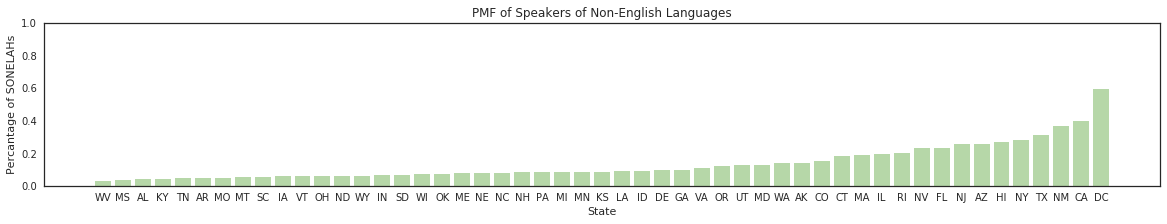

In [15]:
plotPMFs(df2000)

In the 2000 Census data, "English Only" is repeated multiple times, with different values, and no clear indication of what differentiates the values. We were not able to filter all of it out yet, therefore, data like DC's is nonrepresentative.

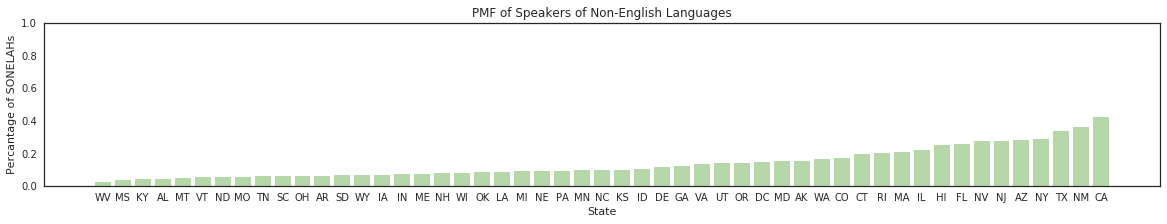

In [16]:
plotPMFs(df2006)

These graphs show on top the portion of the population for each state that only speaks English, and on the bottom the portion of the population for each state that speaks a language other than English. 

We see that a large portion of the population of all U.S. states only speak English. Also, California prominently has a large percent of speakers of non-English languages.

In this year, which states are have most SONELAHs and which have the least?

In [17]:
returnStatesfromRatio(english2006, other2006, 0.2, "More")

AZ
CA
FL
HI
IL
MA
NV
NJ
NM
NY
RI
TX


Here we have all the states in which SONELAHs make up 20 percent or more of their populations. We expected a lot of these states to appear on this list. A number of them are located in the southwest, which was previously owned by Mexico and has always had a very high population of spanish speakers. There is also a number of states from the eastern coast of the united states, which is a common point of entry for immigants into the united states.

In [18]:
returnStatesfromRatio(english2006, other2006, 0.075, "Less")

AL
AR
IN
IA
KY
ME
MS
MO
MT
ND
OH
SC
SD
TN
VT
WV


These states all have 7.5% or less consists of SONELAHs. These results are also expected because states that lie within middle America have a tendency to have contain very small populations of SONELAHs.

What is the state with the least amount of SONELAHs and what percentage of the state do they comprise?

In [19]:
#Returning Which State Had the Least Amount of Non-English Speakers and How many
othernorm2006 = (other2006[0:50]/(english2006[0:50]+other2006[0:50])) 
print(str(states[othernorm2006.idxmin()])) #State in 2006 with smallest number of non-English speakers
print(str(othernorm2006.min()))

WV
0.0228287000426


West Virginia only has 2.28% of its population speak a non-English language at home.

Now we will plot the data for 2009 so that we can compare the change from the previous years

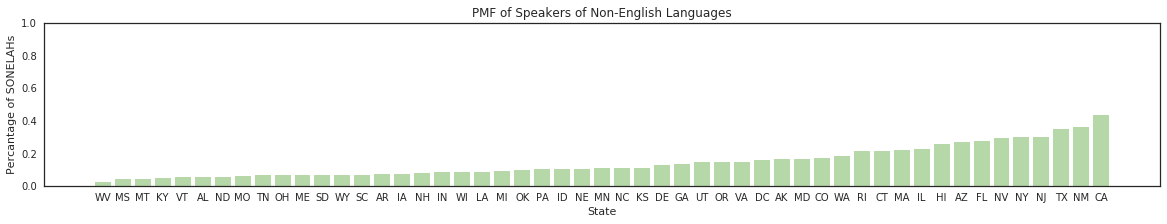

In [20]:
plotPMFs(df2009)

This generally looks the same as the year before.

In [21]:
returnStatesfromRatio(english2009, other2009, 0.2, "More")

AZ
CA
CT
FL
HI
IL
MA
NV
NJ
NM
NY
RI
TX


In [22]:
returnStatesfromRatio(english2009, other2009, 0.1, "Less")

AL
AR
IN
IA
KY
LA
ME
MI
MS
MO
MT
NH
ND
OH
OK
SC
SD
TN
VT
WV
WI


The states which have more than 20% non-English speakers and those which have less than 10% non-English speakers are the same for both years. The graphs also look visually similar.

In the time frame in which we tested change, the demographics do not seem to change. However, we acknowledge that we did not have a lot of temporal data points, and believe that on a larger time frame, demographics have changed in proportions to each other. 

On the other hand, this data shows that some states have more non-English speakers by ratio than others. This could mean that those states are more culturally diverse.

## Amount of Non-English Speakers per County in Potentially Interesting States

Next we will look at counties of states which had some of the most extreme ratios of speakers of only english to speakers of other languages. We will do this to answer : "How is cultural diversity, through linguistic diversity, spread out throughout the U.S.? " on a small scale.

In [23]:
def createCountySeries(countyList, countyNumbers, state ):
    """
    Takes in two empty series and a state.
    countyList - a list which will be populated with names of counties in state
    countyNumbers - a list containing total speakers of other languages per county
    state - state you wish to look at, given as ex: ["AZ"]
    index - the row number in which t
    """
    textfileName = "/home/jobanner/The-Mother-Tongue-of-US-Communities/raw_data/LanguageSpokenatHome_County_2009-2013.xls"
    i=0
    x1 = pd.ExcelFile(textfileName)
    sheetnames = x1.sheet_names
    for sheet in sheetnames:
        if any(x in sheet for x in state):
            df = pd.read_excel(textfileName,sheet, skiprows=[0,1,2,3]).dropna()
            #dictionary[area] = df.loc[1:2,"Number of speakers"]
            countyList.set_value(i,df["Number of speakers1"][1])
            countyNumbers.set_value(i, sheet)
            i+=1

The function above takes in a given state, a list of its counties and the number of counties that it has, then returns a series that has the number of SONELAHs in each county in a state in 2009.

In [30]:
def plotCounty(statename,df):
    """
    Takes in the name of a state, and the two series which createCountySeries filled
    Plots the number of speakers of other languages by county
    """
    dft=df
    dft=dft.sort_values(by="SONELAHs")
    # Determines size of plot
    while True:
        if len(dft)>5:
            plt.figure(figsize=(20, 3))
            break
        else:
            plt.figure()
            break
    i=0
    for thing in dft["SONELAHs"]: 
        plt.bar(i, thing, color='#B6D7A8')
        plt.autoscale(enable=True)
        plt.xticks(range(0,len(dft)), dft["County"],  rotation=70)
        plt.title("Other Language Speakers in "+str(statename)+" by County")
        plt.xlabel("County")
        plt.ylabel("Number of Other Language Speakers")
        i+=1

### California Counties
California contained the greatest percentage of non-English speakers. Are all counties equally contributing to this statistic?
CA, WA, PA, NY, MI

In [31]:
#creating series and calculating non-English speakers per county
CAcounty = pd.Series()
otherspeakers_CAcounties = pd.Series()
createCountySeries(otherspeakers_CAcounties, CAcounty,["CA"])
dfCA=pd.DataFrame({"County":CAcounty, "SONELAHs":otherspeakers_CAcounties})

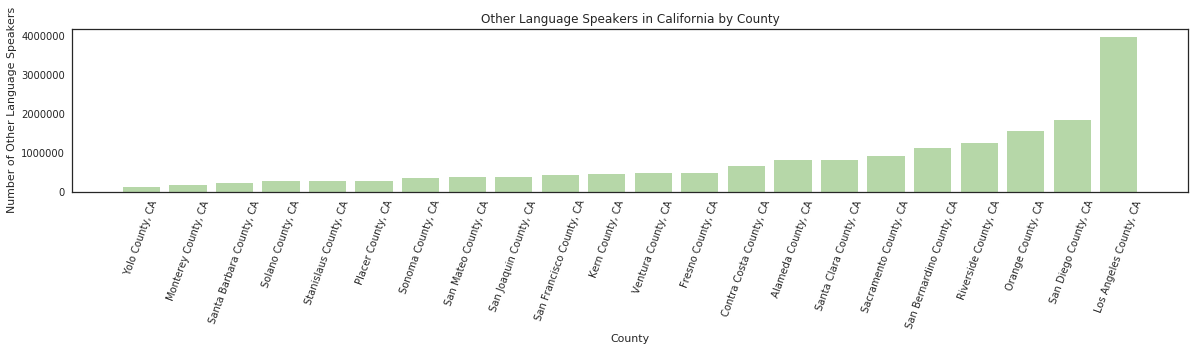

In [32]:
plotCounty("California",dfCA)

It looks like the answer is no. Los Angeles has substantially more non-English speakers than any other California county. Los Angeles might also have more people in general than other counties. We will explore this later.

### New York Counties

New York is known for being the first place to which immigrants come. Let's see how many more immigrants New York, New York has than upstate New York counties.

In [33]:
#creating series and calculating non-English speakers per county
NYcounty = pd.Series()
otherspeakers_NYcounties = pd.Series()
createCountySeries(otherspeakers_NYcounties, NYcounty,["NY"])
dfNY=pd.DataFrame({"County":NYcounty, "SONELAHs":otherspeakers_NYcounties})

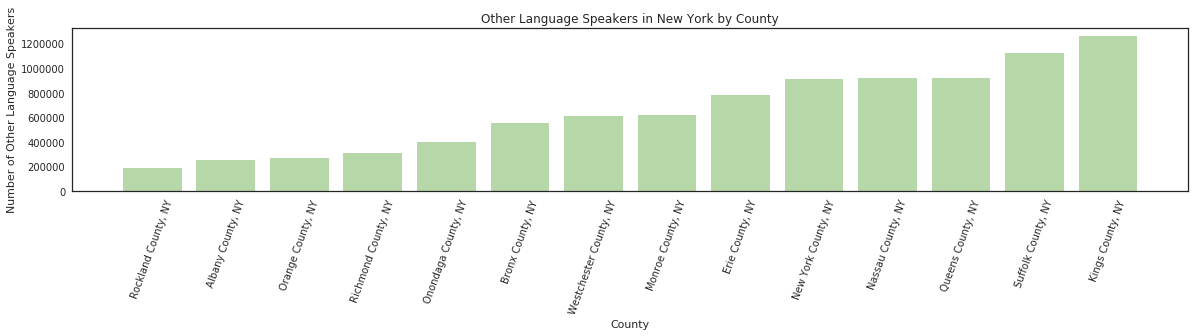

In [34]:
plotCounty("New York",dfNY)

We were not expecting the number of non-English speakers in New York counties to be spread out to this extent. However, New York New York, Kings County, Queens county and Bronx county are all adjacent to each other, and all part of the major urban sprawl of the city of New York. If we group them together, we should find that New York City is contributing greatly to the number of non-English speakers in New York State.

### Pennsylvania Counties

Pennsylvania was one of the states which had a smaller portion of non-English speakers. How does it look inside the state?

In [35]:
#creating series and calculating non-English speakers per county
PAcounty = pd.Series()
otherspeakers_PAcounties = pd.Series()
createCountySeries(otherspeakers_PAcounties, PAcounty,["PA"])
dfPA=pd.DataFrame({"County":PAcounty, "SONELAHs":otherspeakers_PAcounties})

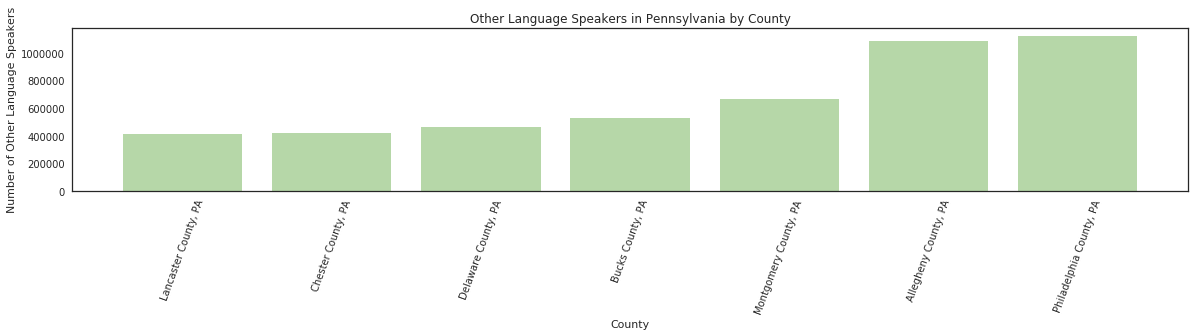

In [36]:
plotCounty("Pennsylvania", dfPA)

Some counties have more non-English speakers while others have less. Taking into consideration the distribution of rural and urban environments in Pennsylvania, this seems reasonable.

Overall, there appears to be more diversity in urban centers, which makes sense, because there are more people and more employment opportunities in these places.

## Analyzing Ratios of Different Languages Spoken in States and Counties

How diverse are the most linguistically diverse communities actually? We stipulate that if all the different languages spoken in a community are, for example, European languages, that changes the perception of how diverse the community is. In this way, we hope to answer the question "Are regions with high ratios of non-English speakers actually linguistically diverse or homogenuously consisting of a non-English speaking community? "

In [37]:
def createListofLanguageGroups(textfileName, arrayNames, column1, skiprows):
    """
    Takes in census year and returns dataframe which contains language groups and corresponding number of respondents
    who speak a language in the language group
    
    textfileName - name of file
    arrayNames - either state or statesfull, depending on Excel file's sheet names
    column1 - because on 2006 the column is "Number of speakers" but on 2009, it's "Number of speakers1"
    skiprows - also depending on dataframe, we either skip [0,1,2] rows or [0,1,2,3] rows
    """
    #Accounting for different formatting of language names in different excel files
    if textfileName == txtfile2009:
         languagegroupstolookfor = ["SPANISH AND SPANISH CREOLE", ".Italian","..German", ".Scandinavian languages",
                              "ASIAN AND PACIFIC ISLAND LANGUAGES",".Navajo", ".Other Native North American languages"]
    elif textfileName == txtfile2006:
        languagegroupstolookfor = ["\nSPANISH AND SPANISH CREOLE", ".Italian",".German", ".Scandinavian languages",
                                  "\nASIAN AND PACIFIC ISLAND LANGUAGES",".Navajo", ".Other Native North American languages"]
    
    #Creating an emtpy dataframe 
    languagesperState = pd.DataFrame(np.nan, index=np.array(arrayNames), columns=np.array(languagegroupstolookfor)) #row index will be language and column index will be column index

    #Looping through the sheets and if the language is there, add it
    for area in arrayNames:

        df = pd.read_excel(textfileName, area, skiprows=skiprows).dropna()
        
        for language in languagegroupstolookfor:

            try:
                num = df[df['Unnamed: 0']==language][column1].item() #select row from langauges column which has certain language
            except:
                num = 0
            languagesperState.loc[area, language] = num
    
    #Putting Some Languages into Categories and Deleting the Individual Ones
    languagesperState['German, Scandinavian, Italian'] = languagesperState.iloc[:, 1:4].sum(axis=1)
    languagesperState['Native North American'] = languagesperState.iloc[:, 5:7].sum(axis=1)
    languagesperState.drop([".Italian","..German", ".Scandinavian languages",".Navajo", ".Other Native North American languages"], axis = 1, inplace = True) 
 
    return languagesperState

In [38]:
def createCountiesList(statename):
    """
    Creates a list of counties from the 2009-2013 counties list, when you input a state you want to analyze
    """
    textfileName =  "/home/jobanner/The-Mother-Tongue-of-US-Communities/raw_data/LanguageSpokenatHome_County_2009-2013.xls"
    countyNames = []
    x1 = pd.ExcelFile(textfileName)
    sheetnames = x1.sheet_names                        
    for sheet in sheetnames:
        if any(x in sheet for x in statename):
            
            countyNames.append(str(sheet))

    return countyNames

In [39]:
def createListofLanguageGroupsCounties(statename):
    """
    Takes in census year and returns dataframe which contains language groups and corresponding number of respondents
    who speak a language in the language group
    
    """
    #Reading Excel spreadsheet
    textfileName =  "/home/jobanner/The-Mother-Tongue-of-US-Communities/raw_data/LanguageSpokenatHome_County_2009-2013.xls"
    #Initializing languages which we are looking for
    languagegroupstolookfor = ["SPANISH AND SPANISH CREOLE", ".Italian","..German", ".Scandinavian languages",
                                 "ASIAN AND PACIFIC ISLAND LANGUAGES",".Navajo", ".Other Native North American languages"]
    #Initializing counties list 
    countyNames = createCountiesList(statename)
    #Create emtpy dataframe
    languagesperState = pd.DataFrame(np.nan, index= np.array(countyNames), columns=np.array(languagegroupstolookfor)) #row index will be language and column index will be column index
    #Looping through the sheets and if the language and county are there, add it
    x1 = pd.ExcelFile(textfileName)
    sheetnames = x1.sheet_names
    for sheet in sheetnames:

        if sheet in countyNames:

            df = pd.read_excel(textfileName, sheet, skiprows=[0,1,2,3]).dropna()
            
            for language in languagegroupstolookfor:
                try:
                    num = df[df['Unnamed: 0']==language]["Number of speakers1"].item()/(df["Number of speakers1"][1]+df["Number of speakers1"][0])#select row from langauges column which has certain language
                    
                except:
                    num = 0
                
                languagesperState.loc[sheet, language] = num
                
     #Putting Some Languages into Categories and Deleting the Individual Ones
    languagesperState['German, Scandinavian, Italian'] = languagesperState.iloc[:, 1:4].sum(axis=1)
    languagesperState['Native North American'] = languagesperState.iloc[:, 5:7].sum(axis=1)
    languagesperState.drop([".Italian","..German", ".Scandinavian languages",".Navajo", ".Other Native North American languages"], axis = 1, inplace = True) 
 

    return languagesperState

In [45]:
def plotCounties(state, language, df):
    countylist = createCountiesList([state])
    dft = df.sort_values(by=language)
    i=0
    plt.figure(figsize=(20, 3))
    for thing in dft[language]: 
        dft = df.sort_values(by=language)
        plt.bar(i, thing,  color='#B6D7A8')
        plt.autoscale(enable=True)
        plt.xticks(range(0,len(countylist)), countylist[0:len(countylist)],  rotation=85)
        plt.title("PMF of "+str(language)+" Speakers by County in "+str(state))
        plt.xlabel("County")
        plt.ylabel("Normalized Probability of "+str(language)+" Speakers")
        i+=1

In [46]:
def plotLanguages(state,countynumber, df):
    countylist = createCountiesList([state])
    rep = countylist[countynumber]

    languagegroups = ["SPANISH AND SPANISH CREOLE", "German, Scandinavian, Italian",
                                 "ASIAN AND PACIFIC ISLAND LANGUAGES","Native North American"]

    plt.figure(figsize=(20, 3))
    
    
    
    for i in range(0,4): 
        plt.bar(i, df[languagegroups[i]][rep])
        plt.autoscale(enable=True)
        plt.xticks(range(0,4), languagegroups[0:len(languagegroups)],  rotation=85)
        plt.title("PMF of Language Speakers in "+str(rep))
        plt.xlabel("County")
        plt.ylabel("Normalized Probability of Speakers")

#### Comparing Spanish Speaking Communities

In [42]:
cali = createListofLanguageGroupsCounties(["CA"])

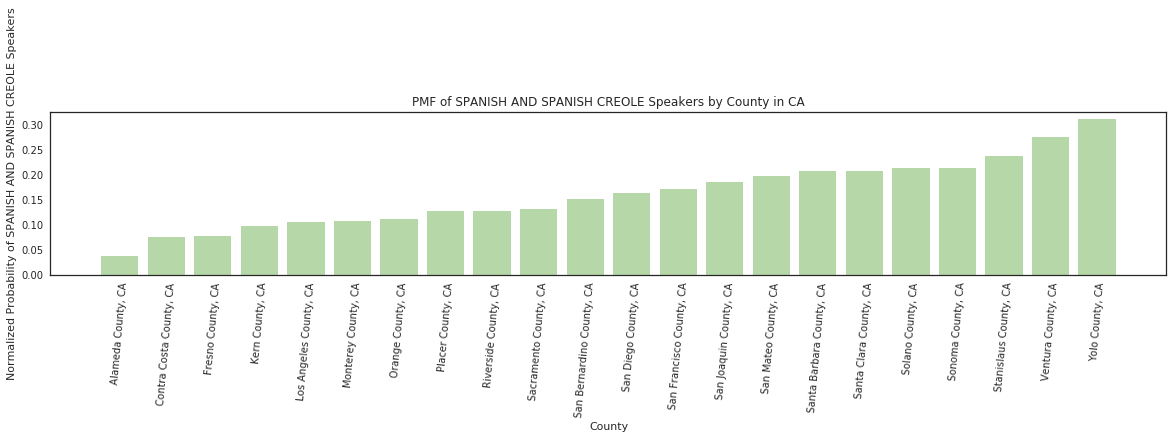

In [47]:
plotCounties("CA", "SPANISH AND SPANISH CREOLE", cali)


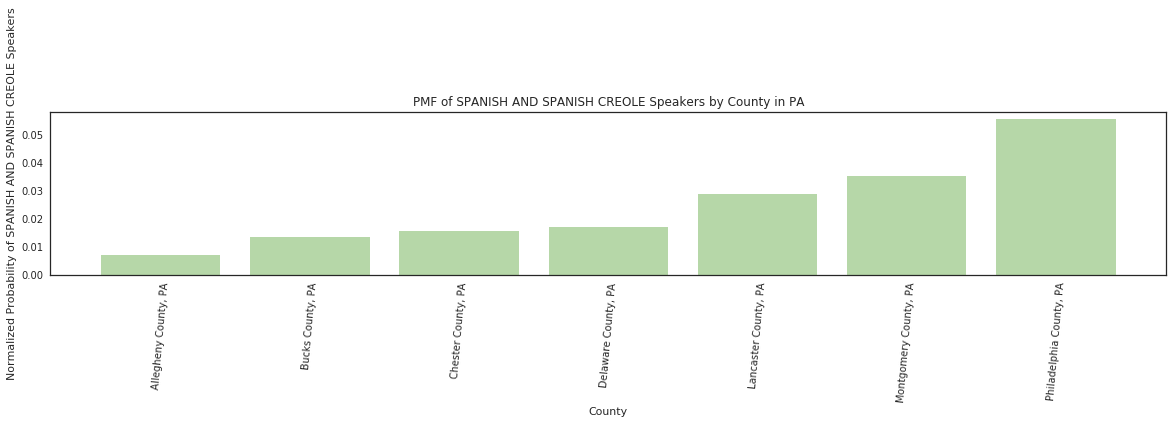

In [48]:
penn= createListofLanguageGroupsCounties(["PA"])
plotCounties("PA", "SPANISH AND SPANISH CREOLE", penn)


Across the board, Spanish has been a very prevalent language within many states and counties. We decided to look at how Spanish speakers spread out across states with both extremes of diversity. We chose California and Pennsylvania because they had a multitude of data points to look at. Looking at the PMF of Spanish speakers within California, it is possible to see that the number of Spanish speakers is not extremely high in any particular region. There are counties with a greater density of spanish speakers, but they are not large enough when compared to their counterparts to be called an extreme. The same can be said for Pennsylvania. The density of spanish speaking populations is not extreme within the larger region (i.e. a state).

#### Comparing the Distribution of European Languages

New York and Massachusetts have higher proportions of non-English speakers. However, these cities have many institutions which are associated with European countries and mindsets, including higher education (study abroad and European literature), research centers and high-profile companies. Does this mean that there are larger proportions of Western European language speakers in these cities than in another city with more non-English speakers, like Dallas?

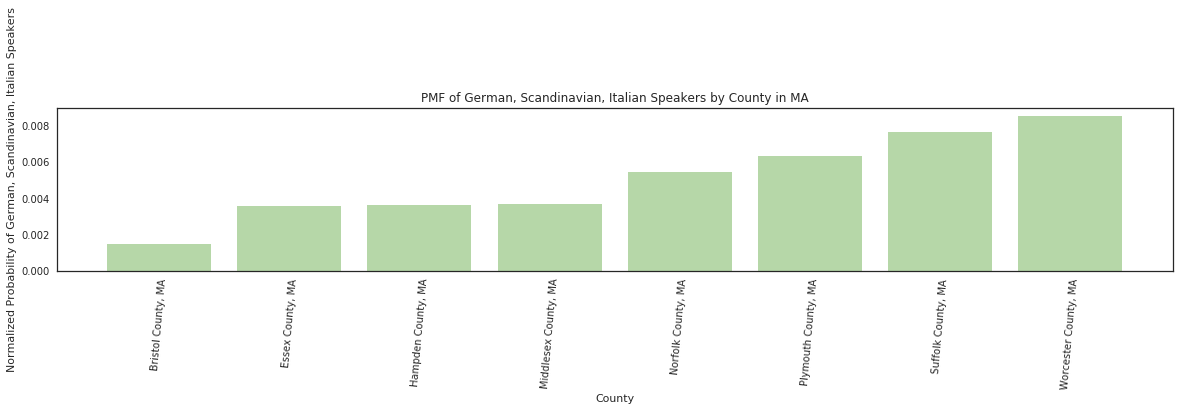

In [49]:
mass= createListofLanguageGroupsCounties(["MA"])
plotCounties("MA", "German, Scandinavian, Italian", mass)

Boston is in Suffolk County, so it is not included in the county which has the highest proportion of Western European speakers in the total population.

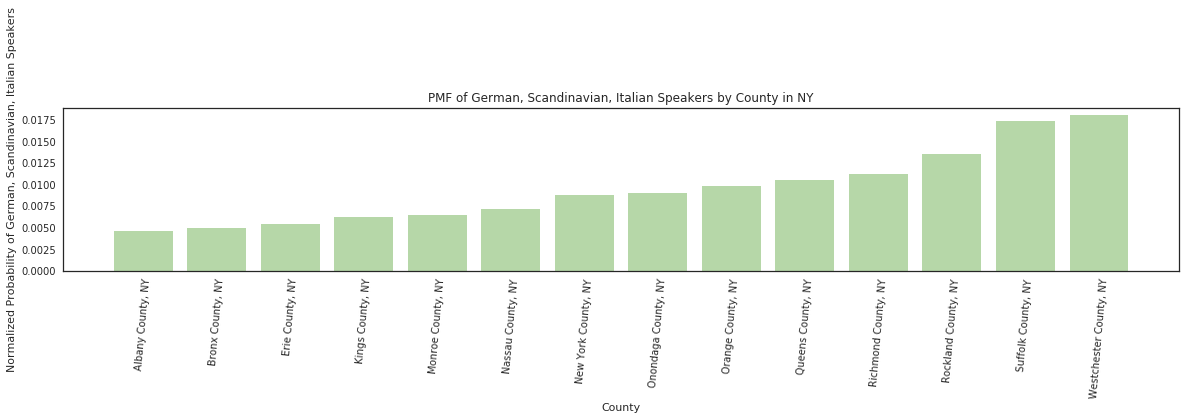

In [50]:
ny= createListofLanguageGroupsCounties(["NY"])
plotCounties("NY", "German, Scandinavian, Italian", ny)

Again, New York City is comprised of multiple counties. However, the two counties that have the highest proportion of Western European speakers (Richmond and Westchester) are not in those counties.

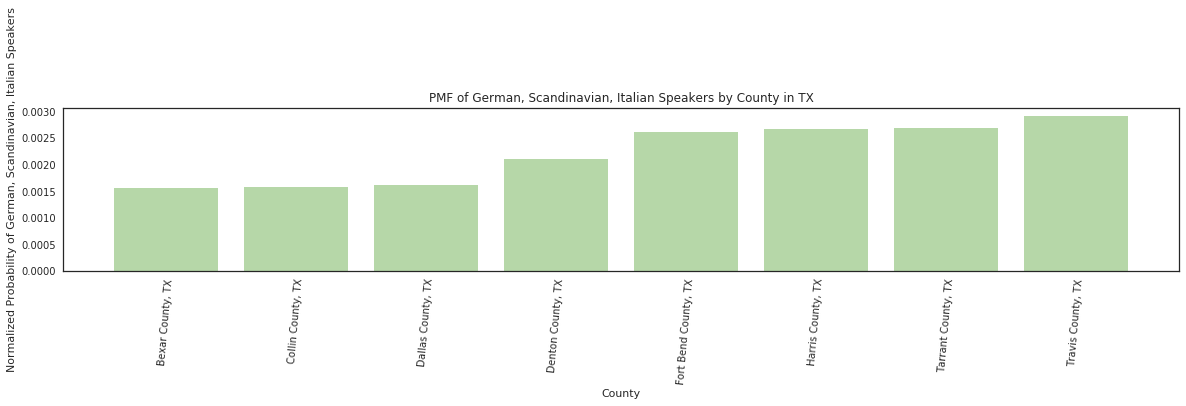

In [51]:
texas= createListofLanguageGroupsCounties(["TX"])
plotCounties("TX", "German, Scandinavian, Italian", texas)

Texas' counties' Western European speaker proportions are all a whole magnitude lower than New York's; regardless if the county contains a major city.

It seems like being in a major city like Boston does not have as much of an effect on the number of Western European language speakers as the larger region the city is situated in.

#### How Diverse is one county?

States like California seem to be more linguistically diverse. Are its counties as well?

Let's take a random county from California and see how much each of our linguistic groups are represented.

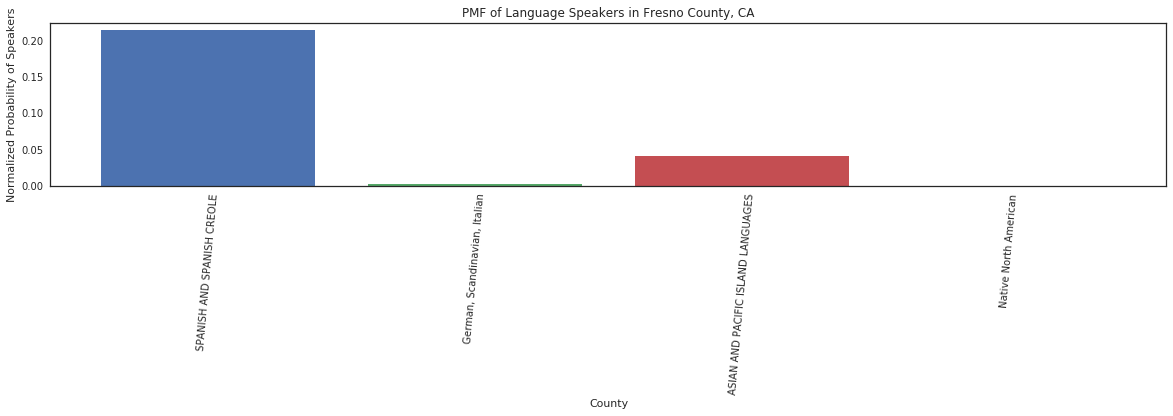

In [52]:
plotLanguages("CA", 2, cali)

There's a huge disproportion of Spanish speakers to our other groups of speakers in Fresno County, CA. 

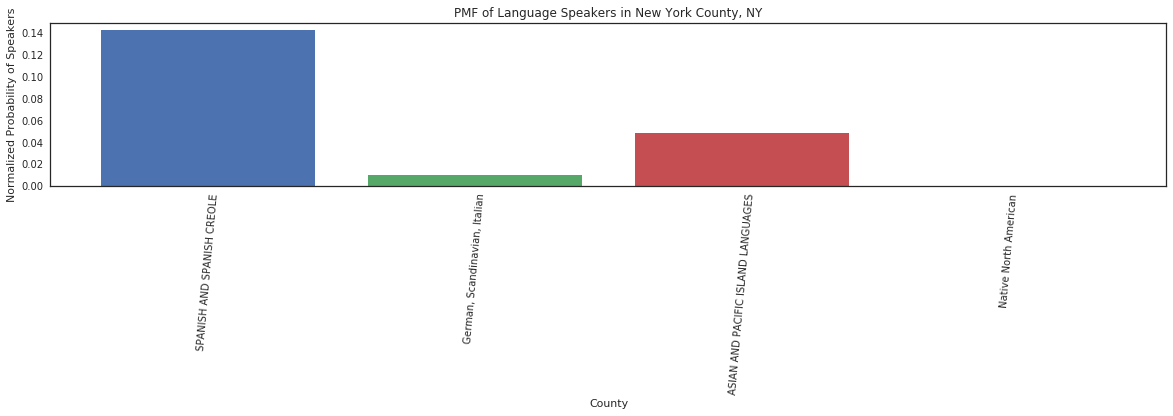

In [53]:
plotLanguages("NY", 6, ny)

There are more Western European speakers in New York, New York.

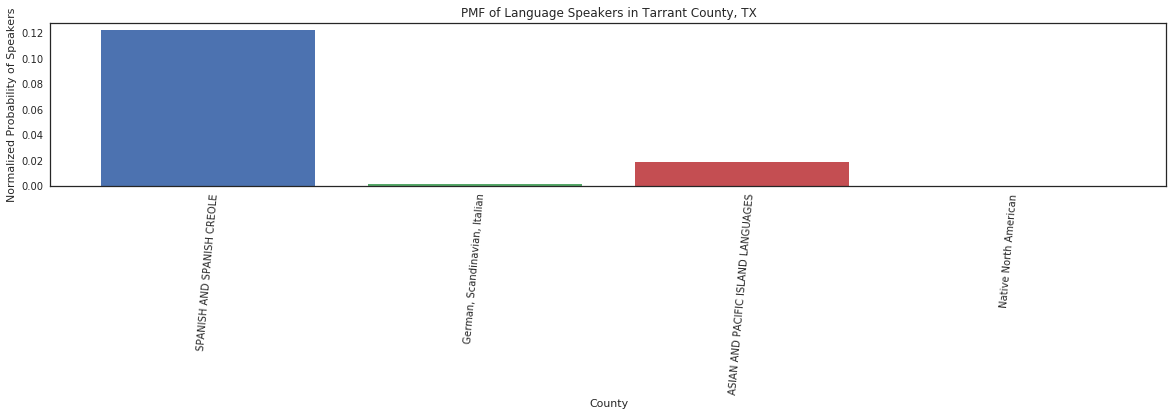

In [54]:
plotLanguages("TX", 6, texas)

It seems that in most counties, regardless of regional location (West Coast, East Coast, South), Spanish speakers are most prominent and speakers of Asian languages are second most prominent. This could have to do with a bias which we did not account for, as explained below in the Overall Conclusion.

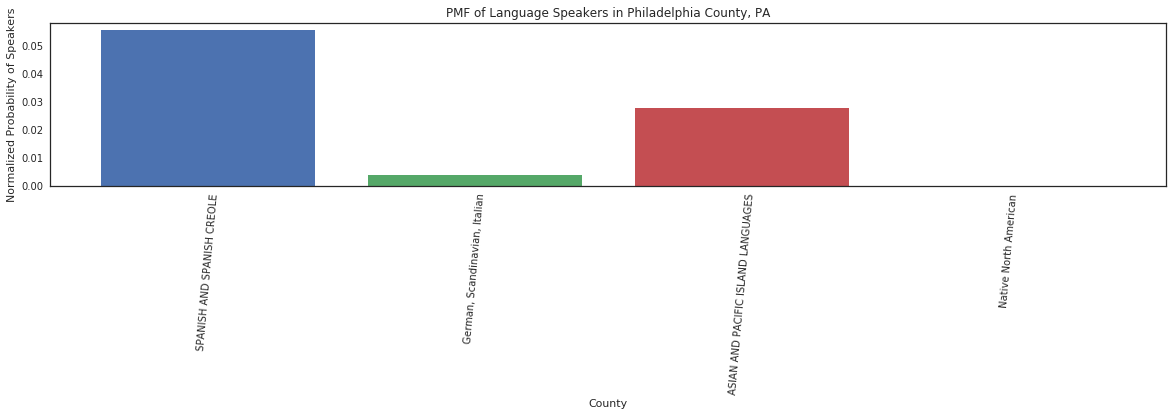

In [55]:
plotLanguages("PA", 6, penn)

Even though Pennsylvania has less non-English speakers, it still seems to have the same ratios of these four language groups.

## Overall Conclusion


There are many points in our analysis which are flawed, not expanded and need to be revised. 
For example, the subset of European languages that we chose are not very representative of the languages people speak in these areas (in terms of Western European languages). This is an example of measurement error.
Including Spanish languages might also skew the data. While most of Latin America speaks Spanish, they are culturally diverse, so this does not represent cultural diversity well. 
Furthermore, we should account for the ratio of people that speak these languages being somewhat set on a national scale (ie: due to physical access).
Another point is that many immigrants do not fill out the Census, and thus the Census representations of linguistic diversity are not accurate. This is an example of sampling error. 

Nonetheless, our data shows that in the small time frame 2006 to 2013, there has not been a significant change in demographics. It also shows that the ratio of Spanish speakers in counties does not change very much in a larger region encompassing those counties, but changing the region will change the ratio of Spanish speakers in the counties. Furthermore, we verified that urban centers have larger amounts of linguistic diversity.

Going back to our origin questions: 

"Has cultural diversity, measured through linguistic diversity, increased significantly in the past few years? How is cultural diversity, through linguistic diversity, spread out throughout the U.S.? Are regions with high ratios of non-English speakers actually linguistically diverse or homogenuously consisting of a non-English speaking community? "
 
We can say that cultural diversity cannot be easily measured with linguistic diversity, and therefore, our estimates of change in cultural diversity over time would not be accurate. Linguistic diversity seems to hold similar ratios throughout the country (see 'How Diverse is one county?'), and we might assume cultural diversity does as well, but more analysis needs to be done for conclusive results. Regions with higher ratios of non-English speakers seem to hold similar ratios of linguistic diversity than regions with lower rations (also see 'How Diverse is one county?'). 


With more time and better data, we could answer these questions in more detail, take into account other factors and be able to analyze more variables in relation to each other. 